# REFMAP laboratory listening test 1 analysis: Rough confirmatory data analysis

## Setup

In [2]:
# import packages
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
import seaborn as sns
import dabest
import warnings
import pingouin as pg

# Suppress FutureWarning messages to quiet pandas
warnings.simplefilter(action='ignore', category=FutureWarning)


Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:00<00:00, 11.93it/s]


Numba compilation complete!


In [3]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

np.random.seed(303)

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set the saveplots toggle to True if plot saving is desired:

In [4]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


### Setup output dataframes

In [5]:
out = pd.DataFrame()
outd = pd.DataFrame()

savedata = True

if savedata:
    # select data output save path
    outDataPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save output data in: \03 Experiment\Experiment 2\Analysis\Python")


### Functions

#### Traditional rounding (for display)

In [6]:
def roundTrad(val, digits=3):
   return np.round(val+10**(-len(str(val))-1), digits)

In [61]:
def displayRndVal(val, digits=3):

    crit = 1/10**digits

    if val < crit:
        valString = "<" + str(crit)
    else:
        valRnd = roundTrad(val, digits)
        dec = int(str(valRnd).split('.')[-1])
        valString = str(valRnd)
        nzeros = digits - len(str(dec))
        if nzeros > 0:
            valString = valString + nzeros*"0"

        # strip any trailing zeros after the last non-zero digit
        valString = valString.rstrip('0').rstrip('.')

    return(valString)

### Import data and organise

In [8]:
# import test data
fileExts = "*.csv"

# participant-wise data
dataBySubjFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest2_testdata_BySubj.csv",
                                                       caption=r"Open refmap_listest2_testdata_BySubj.csv in: \03 Experiment\Experiment 2\Analysis\PostProcess"))[0]
dataBySubjTest = pd.read_csv(dataBySubjFilePath, index_col=False)

# stimulus-wise data
dataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest2_testdata_ByStim.csv",
                                                      caption=r"Open refmap_listest2_testdata_ByStim.csv in: \03 Experiment\Experiment 2\Analysis\PostProcess"))[0]
dataByStimTest = pd.read_csv(dataByStimFilePath, index_col=0)



In [6]:
# categorise columns

for dataset in [dataBySubjTest, dataByStimTest]:
    ambientEnvCats = dataset['AmbientEnv'].unique().tolist().sort()
    uasOperationCats = dataset['UASOperation'].unique().tolist().sort()
    uasTypeCats = dataset['UASType'].unique().tolist().sort()
    
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ambientEnvCats)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], uasOperationCats)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], uasTypeCats)


## Response outlier checking

In this section, the data is first examined for potential anomalies, as possible indicators that particular participants may not have fully understood instructions, or some other reason.

For examining the response judgements (Annoyance, Eventfulness, Pleasantness), the analysis comprises calculating the proportion of outlying data points returned by each participant. Outliers are defined here using the Tukey interquartile criterion of 1.5x the interquartile range above or below the top and bottom quartiles. NB: the Harrell-Davis L-estimator quantile calculation method is used, since the data are continuous, and the sample size per stimulus is relatively small.

In [9]:
# identify the number of ratings each participant gave from the dataBySubj dataset
ratingsCountByParticipant = pd.DataFrame(index=dataBySubjTest['ID'].unique(), dtype=np.int64)
for id, group in dataBySubjTest.groupby('ID'):
    ratingsCountByParticipant.loc[id, 'count'] = group.shape[0]


In [10]:
# Tukey outlier test
kFact = 1.5  # multiplying factor to identify outliers from IQ range

In [11]:
# Annoyance
# get the column names for the first and last Annoyance_ columns in dataByStimTest by detecting them dynamically
annoyance_cols = [col for col in dataByStimTest.columns if col.startswith('Annoyance_')]
first_annoyance_col = annoyance_cols[0]
last_annoyance_col = annoyance_cols[-1]

AnnoyData = dataByStimTest.loc[:, first_annoyance_col:last_annoyance_col]
AnnoyLowQ = AnnoyData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
AnnoyHiQ = AnnoyData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
AnnoyIQ = AnnoyHiQ.values - AnnoyLowQ.values

AnnoyLowOut = AnnoyLowQ.values - kFact*(AnnoyIQ)
AnnoyHiOut = AnnoyHiQ.values + kFact*(AnnoyIQ)

AnnoyOutTest = pd.DataFrame(data=np.logical_or(AnnoyData.values
                                               < AnnoyLowOut,
                                               AnnoyData.values
                                               > AnnoyHiOut),
                            index=AnnoyData.index,
                            columns=[participant.replace("Annoyance_", "")
                                     for participant
                                     in AnnoyData.columns])
AnnoyOutTestScore = AnnoyOutTest.sum(axis=0)
AnnoyOutTestScore.index = AnnoyOutTestScore.index.astype(dtype=int,
                                                         copy=False)
AnnoyOutTestScore.sort_index(inplace=True)

# Pleasantness
pleasantness_cols = [col for col in dataByStimTest.columns if col.startswith('Pleasantness_')]
first_pleasantness_col = pleasantness_cols[0]
last_pleasantness_col = pleasantness_cols[-1]

PleasantData = dataByStimTest.loc[:, first_pleasantness_col:last_pleasantness_col]

PleasantLowQ = PleasantData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
PleasantHiQ = PleasantData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
PleasantIQ = PleasantHiQ.values - PleasantLowQ.values

PleasantLowOut = PleasantLowQ.values - kFact*(PleasantIQ)
PleasantHiOut = PleasantHiQ.values + kFact*(PleasantIQ)

PleasantOutTest = pd.DataFrame(data=np.logical_or(PleasantData.values
                                                  < PleasantLowOut,
                                                  PleasantData.values
                                                  > PleasantHiOut),
                               index=PleasantData.index,
                               columns=[participant.replace("Pleasantness_", "")
                                        for participant in PleasantData.columns])

PleasantOutTestScore = PleasantOutTest.sum(axis=0)
PleasantOutTestScore.index = PleasantOutTestScore.index.astype(dtype=int,
                                                               copy=False)
PleasantOutTestScore.sort_index(inplace=True)

# Eventfulness
eventfulness_cols = [col for col in dataByStimTest.columns if col.startswith('Eventfulness_')]
first_eventfulness_col = eventfulness_cols[0]
last_eventfulness_col = eventfulness_cols[-1]

EventfulData = dataByStimTest.loc[:, first_eventfulness_col:last_eventfulness_col]

EventfulLowQ = EventfulData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
EventfulHiQ = EventfulData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
EventfulIQ = EventfulHiQ.values - EventfulLowQ.values

EventfulLowOut = EventfulLowQ.values - kFact*(EventfulIQ)
EventfulHiOut = EventfulHiQ.values + kFact*(EventfulIQ)
EventfulOutTest = pd.DataFrame(data=np.logical_or(EventfulData.values
                                                  < EventfulLowOut,
                                                  EventfulData.values
                                                  > EventfulHiOut),
                               index=EventfulData.index,
                               columns=[participant.replace("Eventfulness_", "") for participant
                                        in EventfulData.columns])
EventfulOutTestScore = EventfulOutTest.sum(axis=0)
EventfulOutTestScore.index = EventfulOutTestScore.index.astype(dtype=int,
                                                               copy=False)
EventfulOutTestScore.sort_index(inplace=True)

# Total outliers per participant
TotalOutTestScore = AnnoyOutTestScore + PleasantOutTestScore + EventfulOutTestScore

# normalise outlier scores by the number of ratings per participant
TotalOutTestScoreProps = TotalOutTestScore.copy().astype(dtype=float)
for id in TotalOutTestScore.index:
    TotalOutTestScoreProps[id] = TotalOutTestScore[id] / (ratingsCountByParticipant.loc[id, 'count']*3)

AnnoyOutTestScoreProps = AnnoyOutTestScore.copy().astype(dtype=float)
for id in AnnoyOutTestScore.index:
    AnnoyOutTestScoreProps[id] = AnnoyOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']

PleasantOutTestScoreProps = PleasantOutTestScore.copy().astype(dtype=float)
for id in PleasantOutTestScore.index:
    PleasantOutTestScoreProps[id] = PleasantOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']

EventfulOutTestScoreProps = EventfulOutTestScore.copy().astype(dtype=float)
for id in EventfulOutTestScore.index:
    EventfulOutTestScoreProps[id] = EventfulOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']


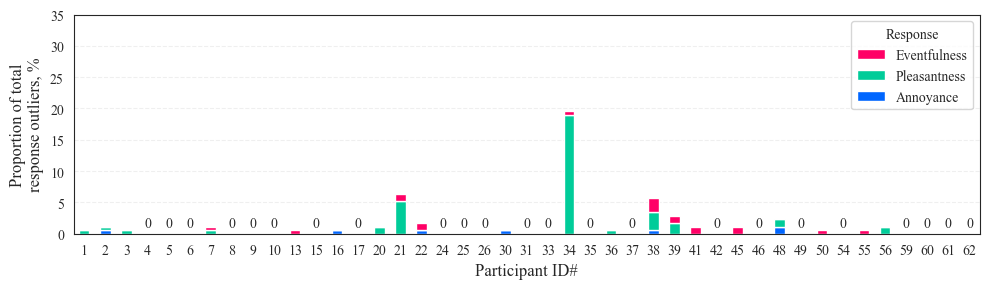

In [107]:
# plot response outliers
fig, ax = plt.subplots(figsize=(10, 3))
OutScoreProps = pd.DataFrame.from_dict({"Annoyance": AnnoyOutTestScoreProps,
                                        "Pleasantness": PleasantOutTestScoreProps,
                                        "Eventfulness": EventfulOutTestScoreProps})
width = 0.5
bottom = np.zeros(EventfulOutTestScore.index.size)

for ii, (responseType, OutScoreProp) in enumerate(OutScoreProps.items()):
    p = ax.bar(OutScoreProp.index.astype(str), 100/3*OutScoreProp, width,
               label=responseType,
               bottom=bottom, color=mycolours[ii])
    bottom += 100/3*OutScoreProp    

barLabels = (100*np.round(TotalOutTestScoreProps, 2)).astype(int).astype(str)
barLabels[TotalOutTestScoreProps != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=OutScoreProp.index.astype(str), yticks=range(0, 40, 5),
       ylabel="Proportion of total" + "\n" + "response outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, len(OutScoreProps.index)-0.5))

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()

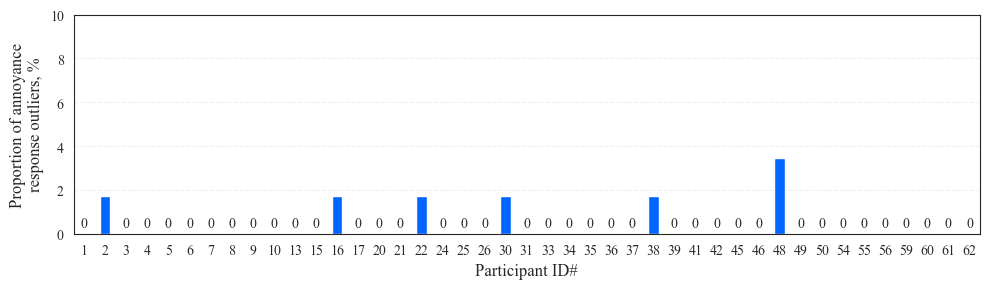

In [108]:
# plot only the annoyance outliers
fig, ax = plt.subplots(figsize=(10, 3))

width = 0.5

p = ax.bar(AnnoyOutTestScoreProps.index.astype(str), 100*AnnoyOutTestScoreProps, width,
           label="Annoyance", color=mycolours[0])

barLabels = (100*np.round(AnnoyOutTestScoreProps, 2)).astype(int).astype(str)
barLabels[AnnoyOutTestScoreProps != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=AnnoyOutTestScoreProps.index.astype(str), yticks=range(0, 12, 2),
       ylabel="Proportion of annoyance" + "\n" + "response outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, AnnoyOutTestScoreProps.index.size-0.5))

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "AnnoyResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "AnnoyResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()


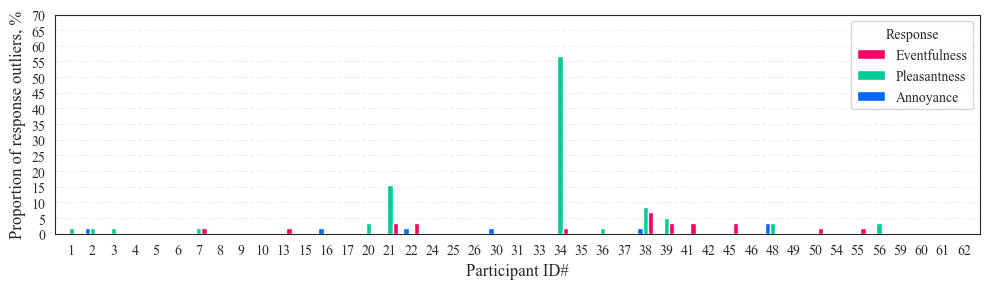

In [109]:
# plot the annoyance, pleasantness, and eventfulness outliers side-by-side instead of stacked
fig, ax = plt.subplots(figsize=(10, 3))

width = 0.25

x = np.arange(len(OutScoreProps.index))

# make plot from OutScoreProps Pandas DataFrame
# plot in reverse order so that legend matches stacked plot

for ii, (responseType, OutScoreProp) in enumerate(OutScoreProps.items()):
    p = ax.bar(x + ii*width, 100*OutScoreProp, width,
               label=responseType,
               color=mycolours[ii])

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=x + width, yticks=range(0, 75, 5),
       xticklabels=OutScoreProp.index.astype(str),
       ylabel="Proportion of response outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, len(OutScoreProps.index)-0.5 + 2*width))

# reverse legend order to match stacked plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ResponseOutliersTukey_separate.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ResponseOutliersTukey_separate.pdf"),
                format='pdf')

In [12]:
# dAnnoyance
# get the column names for the first and last dAnnoyance_ columns in dataByStimTest by detecting them dynamically
dannoyance_cols = [col for col in dataByStimTest.columns if col.startswith('dAnnoyance_')]
first_dannoyance_col = dannoyance_cols[0]
last_dannoyance_col = dannoyance_cols[-1]

dAnnoyData = dataByStimTest.loc[:, first_dannoyance_col:last_dannoyance_col]
dAnnoyLowQ = dAnnoyData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
dAnnoyHiQ = dAnnoyData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
dAnnoyIQ = dAnnoyHiQ.values - dAnnoyLowQ.values

dAnnoyLowOut = dAnnoyLowQ.values - kFact*(dAnnoyIQ)
dAnnoyHiOut = dAnnoyHiQ.values + kFact*(dAnnoyIQ)

dAnnoyOutTest = pd.DataFrame(data=np.logical_or(dAnnoyData.values
                                                < dAnnoyLowOut,
                                                dAnnoyData.values
                                                > dAnnoyHiOut),
                             index=dAnnoyData.index,
                             columns=[participant.replace("dAnnoyance_", "")
                                      for participant
                                      in dAnnoyData.columns])
dAnnoyOutTestScore = dAnnoyOutTest.sum(axis=0)
dAnnoyOutTestScore.index = dAnnoyOutTestScore.index.astype(dtype=int,
                                                           copy=False)
dAnnoyOutTestScore.sort_index(inplace=True)

# dPleasantness
dpleasantness_cols = [col for col in dataByStimTest.columns if col.startswith('dPleasantness_')]
first_dpleasantness_col = dpleasantness_cols[0]
last_dpleasantness_col = dpleasantness_cols[-1]

dPleasantData = dataByStimTest.loc[:, first_dpleasantness_col:last_dpleasantness_col]

dPleasantLowQ = dPleasantData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
dPleasantHiQ = dPleasantData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
dPleasantIQ = dPleasantHiQ.values - dPleasantLowQ.values

dPleasantLowOut = dPleasantLowQ.values - kFact*(dPleasantIQ)
dPleasantHiOut = dPleasantHiQ.values + kFact*(dPleasantIQ)

dPleasantOutTest = pd.DataFrame(data=np.logical_or(dPleasantData.values
                                                   < dPleasantLowOut,
                                                   dPleasantData.values
                                                   > dPleasantHiOut),
                               index=dPleasantData.index,
                               columns=[participant.replace("dPleasantness_", "")
                                        for participant in dPleasantData.columns])

dPleasantOutTestScore = dPleasantOutTest.sum(axis=0)
dPleasantOutTestScore.index = dPleasantOutTestScore.index.astype(dtype=int,
                                                                 copy=False)
dPleasantOutTestScore.sort_index(inplace=True)

# dEventfulness
deventfulness_cols = [col for col in dataByStimTest.columns if col.startswith('dEventfulness_')]
first_deventfulness_col = deventfulness_cols[0]
last_deventfulness_col = deventfulness_cols[-1]

dEventfulData = dataByStimTest.loc[:, first_deventfulness_col:last_deventfulness_col]

dEventfulLowQ = dEventfulData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.25), axis=1).to_frame()
dEventfulHiQ = dEventfulData.apply(lambda row: pg.harrelldavis(row.dropna(), quantile=0.75), axis=1).to_frame()
dEventfulIQ = dEventfulHiQ.values - dEventfulLowQ.values
dEventfulLowOut = dEventfulLowQ.values - kFact*(dEventfulIQ)
dEventfulHiOut = dEventfulHiQ.values + kFact*(dEventfulIQ)
dEventfulOutTest = pd.DataFrame(data=np.logical_or(dEventfulData.values
                                                   < dEventfulLowOut,
                                                   dEventfulData.values
                                                   > dEventfulHiOut),
                               index=dEventfulData.index,
                               columns=[participant.replace("dEventfulness_", "") for participant
                                        in dEventfulData.columns])
dEventfulOutTestScore = dEventfulOutTest.sum(axis=0)
dEventfulOutTestScore.index = dEventfulOutTestScore.index.astype(dtype=int,
                                                                 copy=False)
dEventfulOutTestScore.sort_index(inplace=True)

# Total outliers per participant
dTotalOutTestScore = dAnnoyOutTestScore + dPleasantOutTestScore + dEventfulOutTestScore

# normalise outlier scores by the number of ratings per participant
dTotalOutTestScoreProps = dTotalOutTestScore.copy().astype(dtype=float)
for id in dTotalOutTestScore.index:
    dTotalOutTestScoreProps[id] = dTotalOutTestScore[id] / (ratingsCountByParticipant.loc[id, 'count']*3)

dAnnoyOutTestScoreProps = dAnnoyOutTestScore.copy().astype(dtype=float)
for id in dAnnoyOutTestScore.index:
    dAnnoyOutTestScoreProps[id] = dAnnoyOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']

dPleasantOutTestScoreProps = dPleasantOutTestScore.copy().astype(dtype=float)
for id in dPleasantOutTestScore.index:
    dPleasantOutTestScoreProps[id] = dPleasantOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']

dEventfulOutTestScoreProps = dEventfulOutTestScore.copy().astype(dtype=float)
for id in dEventfulOutTestScore.index:
    dEventfulOutTestScoreProps[id] = dEventfulOutTestScore[id] / ratingsCountByParticipant.loc[id, 'count']


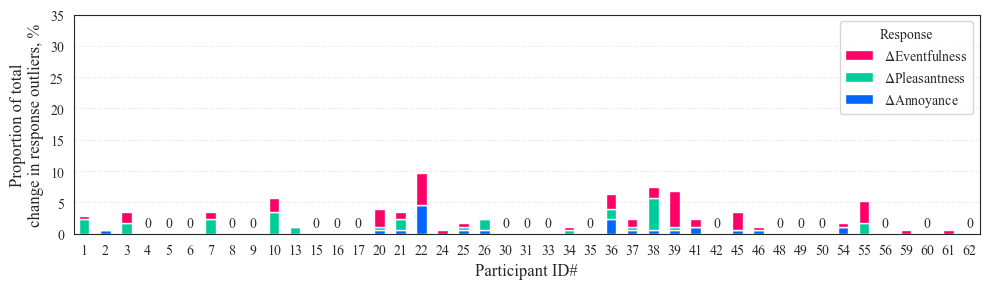

In [115]:
# plot change response outliers
fig, ax = plt.subplots(figsize=(10, 3))
dOutScoreProps = pd.DataFrame.from_dict({r"$\Delta$Annoyance": dAnnoyOutTestScoreProps,
                                         r"$\Delta$Pleasantness": dPleasantOutTestScoreProps,
                                         r"$\Delta$Eventfulness": dEventfulOutTestScoreProps})
width = 0.5
bottom = np.zeros(dEventfulOutTestScore.index.size)

for ii, (responseType, dOutScoreProp) in enumerate(dOutScoreProps.items()):
    p = ax.bar(dOutScoreProp.index.astype(str), 100/3*dOutScoreProp, width,
               label=responseType,
               bottom=bottom, color=mycolours[ii])
    bottom += 100/3*dOutScoreProp

barLabels = (100*np.round(dTotalOutTestScoreProps, 2)).astype(int).astype(str)
barLabels[dTotalOutTestScoreProps != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=OutScoreProp.index.astype(str), yticks=range(0, 40, 5),
       ylabel="Proportion of total" + "\n" + "change in response outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, len(OutScoreProps.index)-0.5))

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ChangeResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ChangeResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()

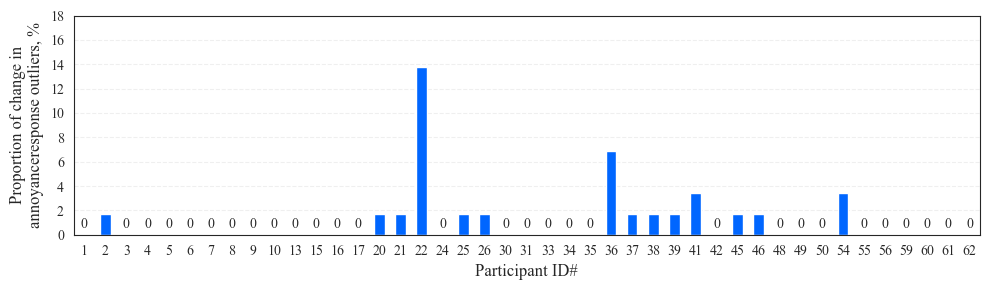

In [116]:
# plot only the change in annoyance outliers
fig, ax = plt.subplots(figsize=(10, 3))

width = 0.5

p = ax.bar(dAnnoyOutTestScoreProps.index.astype(str), 100*dAnnoyOutTestScoreProps, width,
           label=r"$\Delta$Annoyance", color=mycolours[0])

barLabels = (100*np.round(dAnnoyOutTestScoreProps, 2)).astype(int).astype(str)
barLabels[dAnnoyOutTestScoreProps != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=dAnnoyOutTestScoreProps.index.astype(str), yticks=range(0, 20, 2),
       ylabel="Proportion of change in" + "\n" + "annoyanceresponse outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, dAnnoyOutTestScoreProps.index.size-0.5))

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "dAnnoyResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "dAnnoyResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()


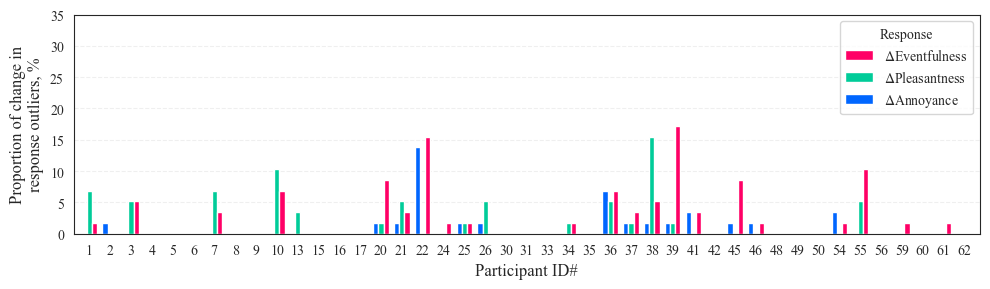

In [119]:
# plot the change in annoyance, pleasantness, and eventfulness outliers side-by-side instead of stacked
fig, ax = plt.subplots(figsize=(10, 3))

width = 0.25

x = np.arange(len(dOutScoreProps.index))

# make plot from dOutScoreProps Pandas DataFrame
# plot in reverse order so that legend matches stacked plot

for ii, (responseType, OutScoreProp) in enumerate(dOutScoreProps.items()):
    p = ax.bar(x + ii*width, 100*OutScoreProp, width,
               label=responseType,
               color=mycolours[ii])

ax.grid(which='major', axis='y', linestyle='--', alpha=0.3)
ax.set(xticks=x + width, yticks=range(0, 40, 5),
       xticklabels=OutScoreProp.index.astype(str),
       ylabel="Proportion of change in" + "\n" + "response outliers, %",
       xlabel="Participant ID#",
       xlim=(-0.5, len(dOutScoreProps.index)-0.5 + 2*width))

# reverse legend order to match stacked plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ChangeResponseOutliersTukey_separate.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ChangeResponseOutliersTukey_separate.pdf"),
                format='pdf')

## Left vs right UAS start position

In [ ]:
# select subset of data for analysis and sort
sharedCols = ['AmbientRef', 'AmbientEnv', 'UASOperation', 'UASType', 'UASStart', 'UASEvents',
              'UASLAEMaxLR', 'UASLAeqMaxLR'
              'AnnoyanceMean', 'PleasantnessMean', 'EventfulnessMean', 'dAnnoyanceMean',
              'dPleasantnessMean', 'dEventfulnessMean']
dataL = dataByStimTest.loc[dataByStimTest['UASStart'] == "Left", sharedCols]
# reindex dataL to omit "_left" from the index
dataL.index = dataL.index.str.replace("_left", "")
# move the index to a column called "Stimulus"
dataL.reset_index(inplace=True)
dataL.rename(columns={"index": "Stimulus"}, inplace=True)

dataR = dataByStimTest.loc[dataByStimTest['UASStart'] == "Right", sharedCols]
# reindex dataR to omit "_right" from the index
dataR.index = dataR.index.str.replace("_right", "")
# move the index to a column called "Stimulus"
dataR.reset_index(inplace=True)
dataR.rename(columns={"index": "Stimulus"}, inplace=True)

data = pd.concat([dataL, dataR], axis=0, ignore_index=True)
data['UASLAEMaxLR5dB'] = np.round(data['UASLAEMaxLR']/5)*5
# convert UASLAeqMaxLR5dB to strings with no decimal places for plotting
data['UASLAEMaxLR5dB'] = data['UASLAEMaxLR5dB'].astype(int).astype(str)



In [ ]:
np.round(data['UASLAeqMaxLR']/5)*5

0      65.0
1      80.0
2      75.0
3      75.0
4      65.0
       ... 
99     85.0
100    80.0
101    80.0
102    85.0
103    80.0
Name: UASLAEMaxLR, Length: 104, dtype: float64

In [99]:
# assign data for processing
dataLoad = dabest.load(data=data, idx=("Left", "Right"), x='UASStart',
                       y='AnnoyanceMean', paired='baseline', id_col='Stimulus',
                       resamples=5000, random_seed=48659, ps_adjust=True)


IndexError: 60 in `palette` is not in the 'UASLAEMaxLR5dB' column of `data`.

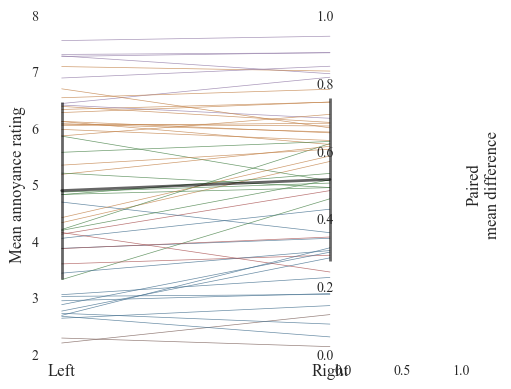

In [100]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 4))
dataMD = dataLoad.mean_diff.plot(slopegraph_kwargs={'linewidth': 0.5, 'alpha': 0.8},
                                 color_col='UASLAEMaxLR5dB', contrast_bars=False,
                                 raw_ylim=(2, 8),
                                 raw_label="Mean annoyance rating",
                                 contrast_marker_size=3.5, show_baseline_ec=True,
                                 legend_kwargs={'bbox_to_anchor': [-1.7, 1.3], 'fontsize':11,
                                                'ncol': 6, 'title': r'UAS $L_\mathrm{AE}$ (nearest 5 dB)'}, ax=ax,
                                 delta_dot_kwargs={'size': 2, 'side': 'left',
                                                   'alpha': 0.5, 'zorder': 1})

diffs = dataLoad.mean_diff.statistical_tests[['difference',
                                              'bca_low',
                                              'bca_high',
                                              'pvalue_permutation']].values

axs = dataMD.axes

# label results
ax.text(x=1.6, y=3.25, s="95%: " + str(roundTrad(diffs[0, 1:3], digits=2)), fontsize=10)
ax.text(x=1.69, y=2.8, s=r"$p$:   " + displayRndVal(diffs[0, 3], digits=3), fontsize=10)


# lgd = axs[0].get_legend()
# for lh in lgd.legend_handles:
#     lh.set_alpha(0)
#     lh.set_linewidth(3)

if saveplots:
    
    filename = "diffLeftRightLAeqDabest"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf', bbox_inches='tight')

dataMD;
dataLoad.mean_diff.statistical_tests


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Left,Right,52,52,mean difference,baseline,0.197904,95,0.067797,0.346612,0.007798,0.020219,434.0,0.008636,-2.731596


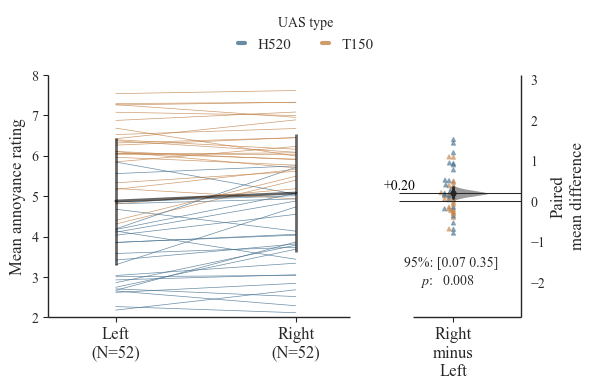

In [85]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 4))
dataMD = dataLoad.mean_diff.plot(slopegraph_kwargs={'linewidth': 0.5, 'alpha': 0.8},
                                 color_col='UASType', contrast_bars=False,
                                 raw_ylim=(2, 8),
                                 raw_label="Mean annoyance rating",
                                 contrast_marker_size=3.5, show_baseline_ec=True,
                                 legend_kwargs={'bbox_to_anchor': [-1.2, 1.3], 'fontsize':11,
                                                'ncol': 2, 'title': r'UAS type'}, ax=ax,
                                 delta_dot_kwargs={'size': 2, 'side': 'left',
                                                   'alpha': 0.5, 'zorder': 1})

diffs = dataLoad.mean_diff.statistical_tests[['difference',
                                              'bca_low',
                                              'bca_high',
                                              'pvalue_permutation']].values

axs = dataMD.axes

# label results
ax.text(x=1.6, y=3.25, s="95%: " + str(roundTrad(diffs[0, 1:3], digits=2)), fontsize=10)
ax.text(x=1.69, y=2.8, s=r"$p$:   " + displayRndVal(diffs[0, 3], digits=3), fontsize=10)


# lgd = axs[0].get_legend()
# for lh in lgd.legend_handles:
#     lh.set_alpha(0)
#     lh.set_linewidth(3)

if saveplots:
    
    filename = "diffLeftRightTypeDabest"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf', bbox_inches='tight')

dataMD;
dataLoad.mean_diff.statistical_tests


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Left,Right,52,52,mean difference,baseline,0.197904,95,0.067797,0.346612,0.007798,0.020219,434.0,0.008636,-2.731596


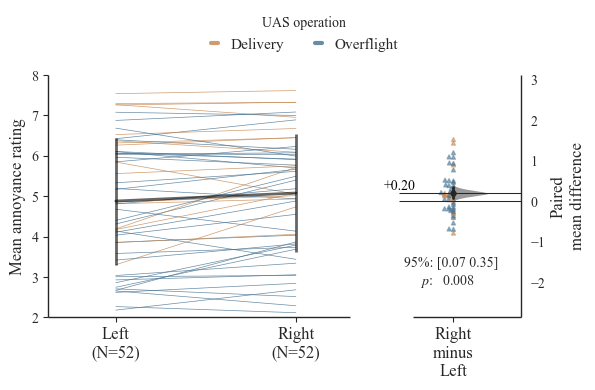

In [84]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 4))
dataMD = dataLoad.mean_diff.plot(slopegraph_kwargs={'linewidth': 0.5, 'alpha': 0.8},
                                 color_col='UASOperation', contrast_bars=False,
                                 raw_ylim=(2, 8),
                                 raw_label="Mean annoyance rating",
                                 contrast_marker_size=3.5, show_baseline_ec=True,
                                 legend_kwargs={'bbox_to_anchor': [-1.4, 1.3], 'fontsize':11,
                                                'ncol': 2, 'title': r'UAS operation'}, ax=ax,
                                 delta_dot_kwargs={'size': 2, 'side': 'left',
                                                   'alpha': 0.5, 'zorder': 1})

diffs = dataLoad.mean_diff.statistical_tests[['difference',
                                              'bca_low',
                                              'bca_high',
                                              'pvalue_permutation']].values

axs = dataMD.axes

# label results
ax.text(x=1.6, y=3.25, s="95%: " + str(roundTrad(diffs[0, 1:3], digits=2)), fontsize=10)
ax.text(x=1.69, y=2.8, s=r"$p$:   " + displayRndVal(diffs[0, 3], digits=3), fontsize=10)


# lgd = axs[0].get_legend()
# for lh in lgd.legend_handles:
#     lh.set_alpha(0)
#     lh.set_linewidth(3)

if saveplots:
    
    filename = "diffLeftRightOperationDabest"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf', bbox_inches='tight')

dataMD;
dataLoad.mean_diff.statistical_tests


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Left,Right,52,52,mean difference,baseline,0.197904,95,0.067797,0.346612,0.007798,0.020219,434.0,0.008636,-2.731596


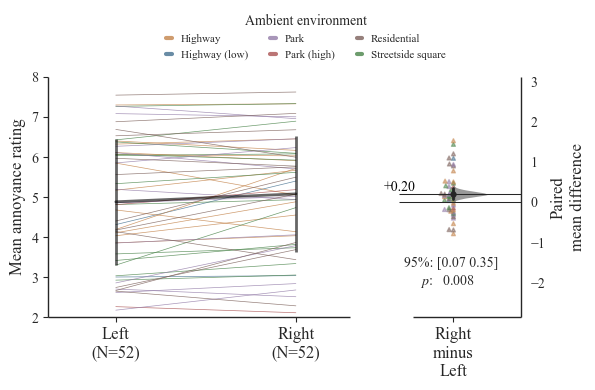

In [83]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 4))
dataMD = dataLoad.mean_diff.plot(slopegraph_kwargs={'linewidth': 0.5, 'alpha': 0.8},
                                 color_col='AmbientEnv', contrast_bars=False,
                                 raw_ylim=(2, 8),
                                 raw_label="Mean annoyance rating",
                                 contrast_marker_size=3.5, show_baseline_ec=True,
                                 legend_kwargs={'bbox_to_anchor': [-1.7, 1.3], 'fontsize':8,
                                                'ncol': 3, 'title': r'Ambient environment'}, ax=ax,
                                 delta_dot_kwargs={'size': 2, 'side': 'left',
                                                   'alpha': 0.5, 'zorder': 1})

diffs = dataLoad.mean_diff.statistical_tests[['difference',
                                              'bca_low',
                                              'bca_high',
                                              'pvalue_permutation']].values

axs = dataMD.axes

# label results
ax.text(x=1.6, y=3.25, s="95%: " + str(roundTrad(diffs[0, 1:3], digits=2)), fontsize=10)
ax.text(x=1.69, y=2.8, s=r"$p$:   " + displayRndVal(diffs[0, 3], digits=3), fontsize=10)


# lgd = axs[0].get_legend()
# for lh in lgd.legend_handles:
#     lh.set_alpha(0)
#     lh.set_linewidth(3)

if saveplots:
    
    filename = "diffLeftRightAmbEnvDabest"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf', bbox_inches='tight')

dataMD;
dataLoad.mean_diff.statistical_tests


In [33]:
lgd.legend_handles

In [ ]:
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Modelled,Scaled,246,246,Cohen's d,baseline,0.0239,95,-0.079853,0.134437,0.647471,0.69952,7362.0,0.662346,-0.437207
